<a href="https://colab.research.google.com/github/FedroVedro/Marking-the-planting-of-rows-of-plants-according-to-the-coordinates-of-the-maps/blob/master/%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B3%D0%B5%D0%BE_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Основной код


##Установка библитек


In [ ]:
!pip install staticmap
!pip install pyproj
!pip install shapely

##Загрузка библиотек

In [ ]:
import os
import json
import csv
import math
import cv2
import numpy as np
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pyproj import Transformer
from staticmap import StaticMap, Line, CircleMarker
from sklearn.cluster import DBSCAN

## Основной блок кода


Выберите способ ввода координат:
1 – Ручной ввод
2 – Загрузка из CSV файла
Ваш выбор (1 или 2): 1
Сколько точек полигона вы хотите ввести? 4
Введите точки в формате 'широта, долгота' (например, 51.696420, 39.507288):
Точка 1: 51.688758, 39.484342
Точка 2: 51.688032, 39.484462
Точка 3: 51.688010, 39.483499
Точка 4: 51.688772, 39.483391
Обработка области: manual

Обработка области: manual
  Сохранено изображение: output/area_manual/images/full_map.png
  Сохранены координаты полигона: output/area_manual/coordinates/points.json
  Сохранено обрезанное изображение: output/area_manual/cropped/cropped_map.png
  Сохранены результаты инференса (маска и overlay) в папке cropped.
Сохранены достоверные координаты рядов в CSV: output/area_manual/lines/lines_coordinates.csv


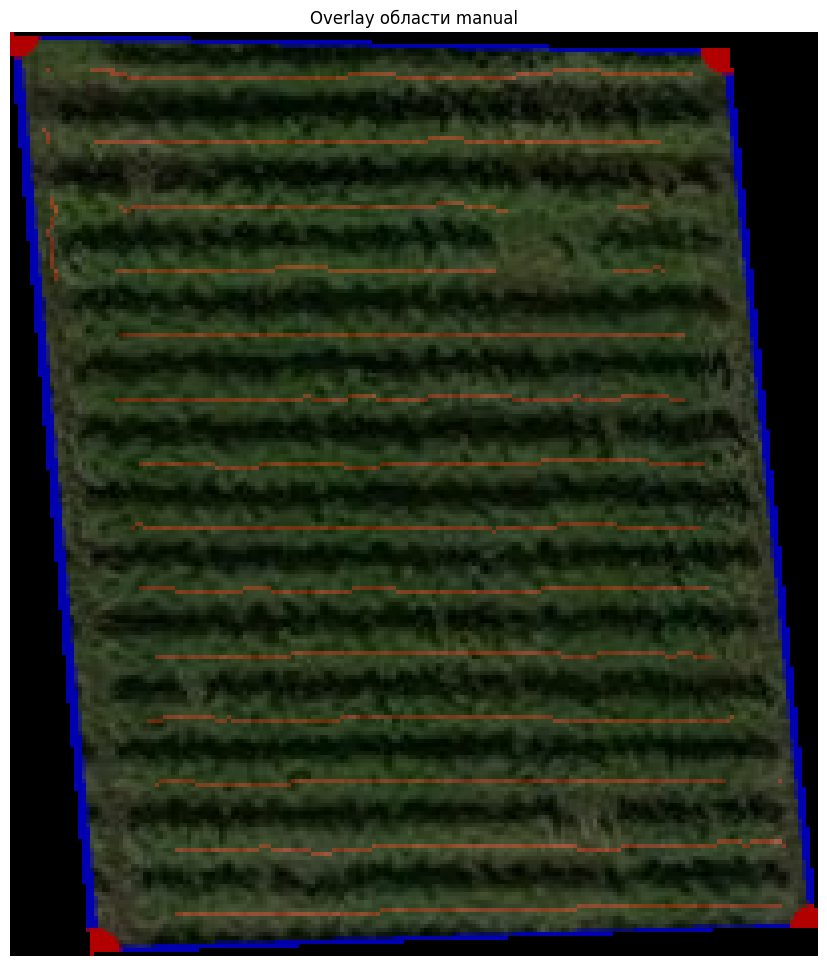

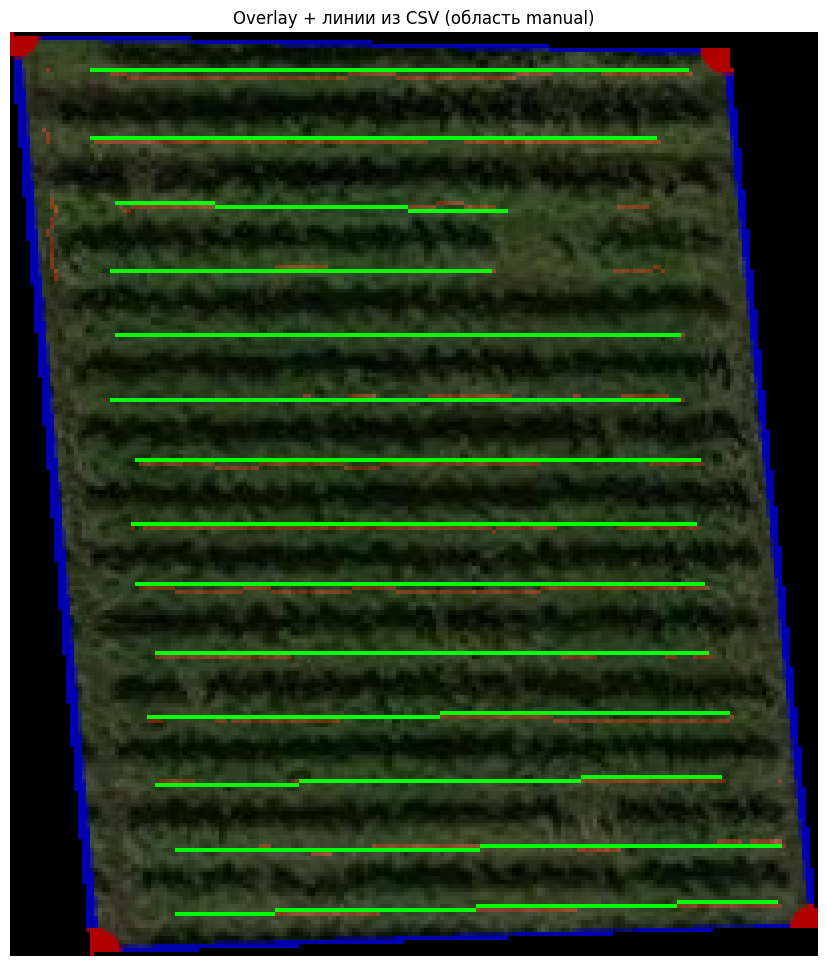

[OK] Сформирован файл с «лесенкой» (DBSCAN-группы): output/area_manual/lines/ladder_connections_dbscan.csv


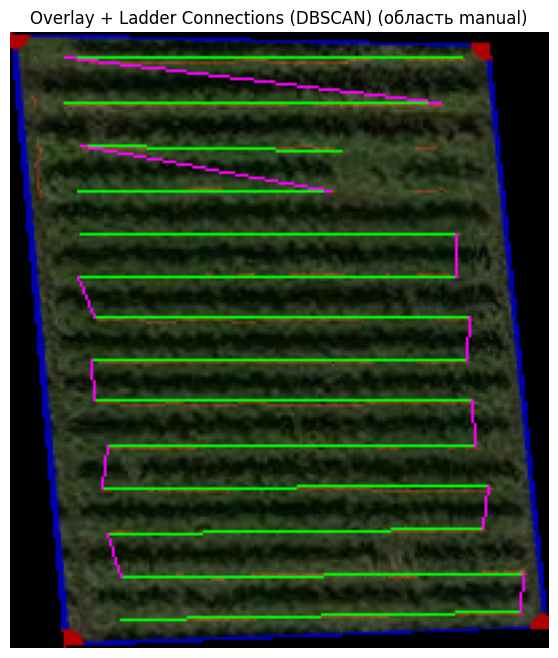

Готово! Сформированы ряды и «лесенка» для области manual.


In [ ]:
import os
import json
import csv
import math
import cv2
import numpy as np
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pyproj import Transformer
from staticmap import StaticMap, Line, CircleMarker
from sklearn.cluster import DBSCAN

# ==========================================
# ФУНКЦИИ ПРЕОБРАЗОВАНИЯ КООРДИНАТ
# ==========================================
def latlon_to_pixel(lat: float, lon: float, zoom: int, map_width: int, map_height: int,
                    center_lat: float, center_lon: float) -> (float, float):
    """
    Преобразует географические координаты (lat, lon) в пиксельные координаты.
    """
    tile_size = 256
    scale = 2 ** zoom

    def project(lat_, lon_):
        x_ = (lon_ + 180) / 360
        siny = math.sin(lat_ * math.pi / 180)
        y_ = 0.5 - math.log((1 + siny) / (1 - siny)) / (4 * math.pi)
        return (x_, y_)

    center_x, center_y = project(center_lat, center_lon)
    point_x, point_y = project(lat, lon)

    world_size = tile_size * scale
    center_px = center_x * world_size
    center_py = center_y * world_size
    point_px = point_x * world_size
    point_py = point_y * world_size

    # Верхний левый угол изображения
    top_left = (center_px - map_width / 2, center_py - map_height / 2)
    pixel_x = point_px - top_left[0]
    pixel_y = point_py - top_left[1]
    return (pixel_x, pixel_y)

def pixel_to_latlon(pixel_x: float, pixel_y: float, zoom: int, map_width: int, map_height: int,
                    center_lat: float, center_lon: float) -> (float, float):
    """
    Обратное преобразование пиксельных координат в (lat, lon).
    """
    tile_size = 256
    scale = 2 ** zoom
    world_size = tile_size * scale

    center_x = (center_lon + 180) / 360
    center_y = 0.5 - math.log(math.tan(math.radians(center_lat)) +
                              1 / math.cos(math.radians(center_lat))) / (2 * math.pi)
    center_px = center_x * world_size
    center_py = center_y * world_size

    top_left = (center_px - map_width / 2, center_py - map_height / 2)
    point_px = pixel_x + top_left[0]
    point_py = pixel_y + top_left[1]

    x = point_px / world_size
    lon = x * 360 - 180
    y = point_py / world_size
    n = math.pi - 2 * math.pi * y
    lat = math.degrees(math.atan(math.sinh(n)))
    return (lat, lon)

def get_endpoints(contour: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Из массива точек контура возвращает пару точек с максимальным расстоянием.
    """
    pts = contour.reshape(-1, 2)
    max_dist = 0
    pt1, pt2 = pts[0], pts[0]
    for i in range(len(pts)):
        for j in range(i + 1, len(pts)):
            d = np.linalg.norm(pts[i] - pts[j])
            if d > max_dist:
                max_dist = d
                pt1, pt2 = pts[i], pts[j]
    return pt1, pt2

# ==========================================
# СОХРАНЕНИЕ КООРДИНАТ РЯДОВ
# ==========================================
def save_lines_coordinates(binary_mask: np.ndarray, M: np.ndarray, inv_transformer: Transformer,
                           csv_path: str, min_line_length: float = 20.0) -> None:
    """
    Извлекает контуры из скелетизированной маски, находит две крайние точки,
    преобразует координаты из пиксельной системы в Web Mercator, а затем в географическую (lat, lon),
    фильтрует по минимальной длине и сохраняет достоверные координаты рядов в CSV.
    """
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lines_csv = []

    for row_id, cnt in enumerate(contours, start=1):
        cnt = cnt.squeeze()
        if cnt.ndim < 2 or cnt.shape[0] < 2:
            continue

        cnt = cnt.astype(np.float32).reshape(-1, 1, 2)
        cnt_transformed = cv2.perspectiveTransform(cnt, M)
        cnt_transformed = cnt_transformed.reshape(-1, 2)

        first_pt, last_pt = get_endpoints(cnt_transformed)
        line_length = np.linalg.norm(first_pt - last_pt)

        if line_length < min_line_length:
            continue

        lon1, lat1 = inv_transformer.transform(first_pt[0], first_pt[1])
        lon2, lat2 = inv_transformer.transform(last_pt[0], last_pt[1])

        lines_csv.append({
            "row_id": row_id,
            "start_lat": lat1,
            "start_lon": lon1,
            "end_lat": lat2,
            "end_lon": lon2
        })

    with open(csv_path, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["row_id", "start_lat", "start_lon", "end_lat", "end_lon"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for row in lines_csv:
            writer.writerow(row)
    print("Сохранены достоверные координаты рядов в CSV:", csv_path)

# ==========================================
# МОДЕЛЬ U-NET
# ==========================================
class UNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1,
                 features: list = [64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Энкодер
        for feature in features:
            self.downs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )
            in_channels = feature

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1] * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features[-1] * 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1] * 2, features[-1] * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features[-1] * 2),
            nn.ReLU(inplace=True)
        )

        # Декодер
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(feature * 2, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)
        return self.final_conv(x)

# ==========================================
# ГЛОБАЛЬНЫЕ НАСТРОЙКИ МОДЕЛИ
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/best_unet.pth"  # замените на путь к вашей модели
model = UNet(in_channels=3, out_channels=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

test_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ==========================================
# ДОПОЛНИТЕЛЬНЫЕ ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
# ==========================================
def rotate_point(x: float, y: float, angle: float) -> (float, float):
    """
    Поворачивает точку (x, y) на угол angle (в радианах).
    """
    u = x * math.cos(angle) - y * math.sin(angle)
    v = x * math.sin(angle) + y * math.cos(angle)
    return u, v

def circular_mean(angles: list) -> float:
    """
    Вычисляет среднее циркулярное значение для списка углов (в радианах).
    """
    sum_sin = sum(math.sin(a) for a in angles)
    sum_cos = sum(math.cos(a) for a in angles)
    return math.atan2(sum_sin, sum_cos)

# ==========================================
# "ЛЕСЕНКА" С ПОМОЩЬЮ DBSCAN-КЛАСТЕРИЗАЦИИ
# ==========================================
def get_top_bottom(lat1, lon1, lat2, lon2):
    """
    Возвращает (top, bottom) в географическом смысле:
    top — та точка, у которой lat больше (выше на карте).
    """
    if lat1 > lat2:
        return (lat1, lon1), (lat2, lon2)
    else:
        return (lat2, lon2), (lat1, lon1)

def get_left_right(lat1, lon1, lat2, lon2):
    """
    Возвращает (left, right) в географическом смысле:
    left — та точка, у которой longitude меньше (находится левее).
    """
    if lon1 < lon2:
        return (lat1, lon1), (lat2, lon2)
    else:
        return (lat2, lon2), (lat1, lon1)

def create_ladder_connections_dbscan(
    lines_csv_path,
    output_csv_path,
    zoom,
    map_width,
    map_height,
    center_lat,
    center_lon,
    eps=100.0,
    min_samples=1,
    orientation: str = "vertical"  # "vertical" или "horizontal"
):
    """
    Создаёт «лесенку» (связи между рядами) с помощью DBSCAN-кластеризации.
    Можно задать ориентацию рядов (vertical или horizontal).
    """
    # 1) Считываем все ряды
    lines_data = []
    with open(lines_csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            row_id = int(row["row_id"])
            lat1 = float(row["start_lat"])
            lon1 = float(row["start_lon"])
            lat2 = float(row["end_lat"])
            lon2 = float(row["end_lon"])
            mid_lat = (lat1 + lat2) / 2.0
            mid_lon = (lon1 + lon2) / 2.0
            lines_data.append({
                "row_id": row_id,
                "start_lat": lat1,
                "start_lon": lon1,
                "end_lat": lat2,
                "end_lon": lon2,
                "mid_lat": mid_lat,
                "mid_lon": mid_lon
            })

    # 2) Переводим midpoint в пиксели
    points = []
    for line in lines_data:
        px, py = latlon_to_pixel(
            line["mid_lat"], line["mid_lon"],
            zoom, map_width, map_height,
            center_lat, center_lon
        )
        points.append([px, py])
    points = np.array(points, dtype=np.float32)

    # 3) DBSCAN-кластеризация
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = clustering.labels_  # массив меток кластеров для каждой строки

    # Запишем метки кластера в lines_data
    for i, lbl in enumerate(labels):
        lines_data[i]["cluster"] = lbl

    # Сгруппируем по кластерам
    clusters_dict = {}
    for line in lines_data:
        c = line["cluster"]
        if c == -1:
            continue  # пропускаем шум
        if c not in clusters_dict:
            clusters_dict[c] = []
        clusters_dict[c].append(line)

    # Словарь для соответствия row_id -> (px, py)
    rowid_to_pxpy = {}
    for i, line in enumerate(lines_data):
        rowid_to_pxpy[line["row_id"]] = (points[i][0], points[i][1])

    connections = []
    for cluster_label, lines_in_cluster in clusters_dict.items():
        # Сортировка внутри кластера по направлению:
        if orientation == "vertical":
            lines_in_cluster.sort(key=lambda d: rowid_to_pxpy[d["row_id"]][1])
        elif orientation == "horizontal":
            lines_in_cluster.sort(key=lambda d: rowid_to_pxpy[d["row_id"]][0])
        else:
            raise ValueError("Неверное значение параметра orientation. Ожидается 'vertical' или 'horizontal'.")

        # Строим «лесенку»
        for i in range(len(lines_in_cluster) - 1):
            current_line = lines_in_cluster[i]
            next_line = lines_in_cluster[i + 1]

            row_id_cur = current_line["row_id"]
            row_id_next = next_line["row_id"]

            if orientation == "vertical":
                # Используем верхние и нижние края ряда
                top_cur, bottom_cur = get_top_bottom(
                    current_line["start_lat"], current_line["start_lon"],
                    current_line["end_lat"], current_line["end_lon"]
                )
                top_next, bottom_next = get_top_bottom(
                    next_line["start_lat"], next_line["start_lon"],
                    next_line["end_lat"], next_line["end_lon"]
                )
                if i % 2 == 0:
                    start_lat, start_lon = top_cur
                    end_lat, end_lon = top_next
                    connect_type = "top->top"
                else:
                    start_lat, start_lon = bottom_cur
                    end_lat, end_lon = bottom_next
                    connect_type = "bottom->bottom"
            elif orientation == "horizontal":
                # Используем левую и правую стороны ряда
                left_cur, right_cur = get_left_right(
                    current_line["start_lat"], current_line["start_lon"],
                    current_line["end_lat"], current_line["end_lon"]
                )
                left_next, right_next = get_left_right(
                    next_line["start_lat"], next_line["start_lon"],
                    next_line["end_lat"], next_line["end_lon"]
                )
                if i % 2 == 0:
                    start_lat, start_lon = left_cur
                    end_lat, end_lon = left_next
                    connect_type = "left->left"
                else:
                    start_lat, start_lon = right_cur
                    end_lat, end_lon = right_next
                    connect_type = "right->right"

            connections.append({
                "cluster_label": cluster_label,
                "from_row": row_id_cur,
                "to_row": row_id_next,
                "connection_type": connect_type,
                "start_lat": start_lat,
                "start_lon": start_lon,
                "end_lat": end_lat,
                "end_lon": end_lon
            })

    # 5) Сохраняем результаты в CSV
    fieldnames = [
        "cluster_label", "from_row", "to_row", "connection_type",
        "start_lat", "start_lon", "end_lat", "end_lon"
    ]
    with open(output_csv_path, "w", encoding="utf-8", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        for conn in connections:
            writer.writerow(conn)

    print(f"[OK] Сформирован файл с «лесенкой» (DBSCAN-группы): {output_csv_path}")

# ==========================================
# ОСНОВНАЯ ФУНКЦИЯ ОБРАБОТКИ ОБЛАСТИ
# ==========================================
def process_area(area_id: str, points_ll: list):
    """
    Обрабатывает область:
      1. Рендерит статическую карту.
      2. Сохраняет координаты полигона.
      3. Создаёт маску, проводит инференс модели и обрезку.
      4. Вычисляет матрицу гомографии.
      5. Сохраняет координаты обнаруженных рядов.
      6. Визуализирует overlay и линии (без автоматических преобразований цвета).
      7. Формирует «лесенку» с DBSCAN-кластеризацией.
    """
    print(f"\nОбработка области: {area_id}")
    if points_ll[0] != points_ll[-1]:
        points_ll.append(points_ll[0])

    n_points = len(points_ll) - 1  # исключая дублирование последней точки
    center_lat = sum(pt[0] for pt in points_ll[:-1]) / n_points
    center_lon = sum(pt[1] for pt in points_ll[:-1]) / n_points

    zoom = 18
    map_width = 2048
    map_height = 2048

    # Создаём папки для сохранения
    base_dir = os.path.join("output", f"area_{area_id}")
    images_dir = os.path.join(base_dir, "images")
    coordinates_dir = os.path.join(base_dir, "coordinates")
    cropped_dir = os.path.join(base_dir, "cropped")
    lines_dir = os.path.join(base_dir, "lines")
    for d in [images_dir, coordinates_dir, cropped_dir, lines_dir]:
        os.makedirs(d, exist_ok=True)

    # 1) Рендеринг статической карты
    m = StaticMap(map_width, map_height,
                  url_template='https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}')
    polygon_coords = [(pt[1], pt[0]) for pt in points_ll]
    polygon_line = Line(polygon_coords, 'blue', 3)
    m.add_line(polygon_line)
    for pt in polygon_coords:
        marker = CircleMarker(pt, 'red', 12)
        m.add_marker(marker)
    rendered_img = m.render(zoom=zoom, center=(center_lon, center_lat))
    full_image_path = os.path.join(images_dir, "full_map.png")
    rendered_img.save(full_image_path)
    print("  Сохранено изображение:", full_image_path)

    # 2) Сохранение координат полигона в JSON
    coords_json = {"points": [{"lat": pt[0], "lon": pt[1]} for pt in points_ll]}
    coords_path = os.path.join(coordinates_dir, "points.json")
    with open(coords_path, "w", encoding="utf-8") as f:
        json.dump(coords_json, f, ensure_ascii=False, indent=2)
    print("  Сохранены координаты полигона:", coords_path)

    # 3) Создание маски и обрезка
    pixel_coords = [latlon_to_pixel(lat, lon, zoom, map_width, map_height, center_lat, center_lon)
                    for (lat, lon) in points_ll]
    mask = Image.new('L', (map_width, map_height), 0)
    draw = ImageDraw.Draw(mask)
    draw.polygon(pixel_coords, fill=255)
    image_rgba = rendered_img.convert("RGBA")
    masked_img = Image.composite(image_rgba, Image.new("RGBA", (map_width, map_height)), mask)
    bbox = mask.getbbox()
    if bbox:
        cropped_img = masked_img.crop(bbox)
    else:
        cropped_img = masked_img
    cropped_path = os.path.join(cropped_dir, "cropped_map.png")
    cropped_img.save(cropped_path)
    print("  Сохранено обрезанное изображение:", cropped_path)

    # 4) Инференс U-Net
    cropped_img_rgb = np.array(cropped_img.convert("RGB"))
    augmented = test_transform(image=cropped_img_rgb)
    input_tensor = augmented["image"].unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        output = torch.sigmoid(output)
    pred_mask = output[0, 0].cpu().numpy()

    # Бинаризация
    threshold = 0.35
    binary_mask = (pred_mask > threshold).astype(np.uint8) * 255

    # Морфологическое закрытие
    kernel = np.ones((5, 5), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Скелетизация
    binary_mask = cv2.ximgproc.thinning(binary_mask, None, cv2.ximgproc.THINNING_ZHANGSUEN)

    # Сохраняем маску и overlay
    binary_mask_path = os.path.join(cropped_dir, "binary_mask.png")
    cv2.imwrite(binary_mask_path, binary_mask)
    colored_mask = np.zeros_like(cropped_img_rgb)
    colored_mask[..., 0] = binary_mask  # красный канал
    overlay = cv2.addWeighted(cropped_img_rgb, 0.7, colored_mask, 0.3, 0)
    overlay_path = os.path.join(cropped_dir, "overlay.png")
    cv2.imwrite(overlay_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print("  Сохранены результаты инференса (маска и overlay) в папке cropped.")

    # 5) Вычисляем матрицу гомографии для преобразования
    xs = [x for (x, y) in pixel_coords]
    ys = [y for (x, y) in pixel_coords]
    x_min, y_min = min(xs), min(ys)
    x_max, y_max = max(xs), max(ys)
    w_cropped = x_max - x_min
    h_cropped = y_max - y_min

    tl_full = (x_min, y_min)
    tr_full = (x_max, y_min)
    br_full = (x_max, y_max)
    bl_full = (x_min, y_max)
    tl_geo = pixel_to_latlon(tl_full[0], tl_full[1], zoom, map_width, map_height, center_lat, center_lon)
    tr_geo = pixel_to_latlon(tr_full[0], tr_full[1], zoom, map_width, map_height, center_lat, center_lon)
    br_geo = pixel_to_latlon(br_full[0], br_full[1], zoom, map_width, map_height, center_lat, center_lon)
    bl_geo = pixel_to_latlon(bl_full[0], bl_full[1], zoom, map_width, map_height, center_lat, center_lon)

    proj_transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    dst_pts = []
    for geo in [tl_geo, tr_geo, br_geo, bl_geo]:
        lat_, lon_ = geo
        x_merc, y_merc = proj_transformer.transform(lon_, lat_)
        dst_pts.append([x_merc, y_merc])
    dst_pts = np.array(dst_pts, dtype=np.float32)

    src_pts = np.array([[0, 0],
                        [w_cropped, 0],
                        [w_cropped, h_cropped],
                        [0, h_cropped]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    inv_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

    # 6) Сохраняем координаты обнаруженных рядов
    lines_csv = os.path.join(lines_dir, "lines_coordinates.csv")
    save_lines_coordinates(binary_mask, M, inv_transformer, lines_csv, min_line_length=50.0)

    # 7) Отображаем overlay
    plt.figure(figsize=(12, 12))
    plt.imshow(overlay)
    plt.title(f"Overlay области {area_id}")
    plt.axis("off")
    plt.show()

    # 8) Наложение линий из CSV на overlay
    overlay_with_lines = overlay.copy()
    with open(lines_csv, "r", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            start_px_full = latlon_to_pixel(float(row["start_lat"]), float(row["start_lon"]),
                                            zoom, map_width, map_height,
                                            center_lat, center_lon)
            end_px_full = latlon_to_pixel(float(row["end_lat"]), float(row["end_lon"]),
                                          zoom, map_width, map_height,
                                          center_lat, center_lon)
            start_cropped = (int(start_px_full[0] - x_min), int(start_px_full[1] - y_min))
            end_cropped = (int(end_px_full[0] - x_min), int(end_px_full[1] - y_min))
            cv2.line(overlay_with_lines, start_cropped, end_cropped, (0, 255, 0), 1)

    plt.figure(figsize=(12, 12))
    plt.imshow(overlay_with_lines)
    plt.title(f"Overlay + линии из CSV (область {area_id})")
    plt.axis("off")
    plt.show()

    # «ЛЕСЕНКА» С DBSCAN-КЛАСТЕРИЗАЦИЕЙ
    dbscan_csv_path = os.path.join(lines_dir, "ladder_connections_dbscan.csv")

    # Задайте ориентацию рядов: "vertical" или "horizontal"
    ladder_orientation = "vertical"  # измените на "horizontal", если ряды расположены горизонтально

    create_ladder_connections_dbscan(
        lines_csv_path=lines_csv,
        output_csv_path=dbscan_csv_path,
        zoom=zoom,
        map_width=map_width,
        map_height=map_height,
        center_lat=center_lat,
        center_lon=center_lon,
        eps=20.0,       # подберите под свой масштаб
        min_samples=1,
        orientation=ladder_orientation
    )

    # Визуализируем «лесенку»
    overlay_with_ladder = overlay_with_lines.copy()
    with open(dbscan_csv_path, "r", encoding="utf-8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            start_px_full = latlon_to_pixel(float(row["start_lat"]), float(row["start_lon"]),
                                            zoom, map_width, map_height,
                                            center_lat, center_lon)
            end_px_full = latlon_to_pixel(float(row["end_lat"]), float(row["end_lon"]),
                                          zoom, map_width, map_height,
                                          center_lat, center_lon)
            sx = int(start_px_full[0] - x_min)
            sy = int(start_px_full[1] - y_min)
            ex = int(end_px_full[0] - x_min)
            ey = int(end_px_full[1] - y_min)
            # Рисуем линию розовым цветом для выделения лестницы
            cv2.line(overlay_with_ladder, (sx, sy), (ex, ey), (255, 0, 255), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_with_ladder)
    plt.title(f"Overlay + Ladder Connections (DBSCAN) (область {area_id})")
    plt.axis("off")
    plt.show()

    print(f"Готово! Сформированы ряды и «лесенка» для области {area_id}.")

# ==========================================
# ГЛАВНАЯ ФУНКЦИЯ
# ==========================================
def main():
    print("Выберите способ ввода координат:")
    print("1 – Ручной ввод")
    print("2 – Загрузка из CSV файла")
    choice = input("Ваш выбор (1 или 2): ").strip()

    areas = []  # список кортежей (area_id, points_ll)

    if choice == "1":
        area_id = "manual"
        try:
            n_points = int(input("Сколько точек полигона вы хотите ввести? "))
        except ValueError:
            print("Неверное число точек!")
            return

        points_ll = []
        print("Введите точки в формате 'широта, долгота' (например, 51.696420, 39.507288):")
        for i in range(n_points):
            while True:
                coord_str = input(f"Точка {i+1}: ")
                try:
                    lat, lon = map(float, coord_str.split(','))
                    points_ll.append((lat, lon))
                    break
                except ValueError:
                    print("Неверный формат ввода. Попробуйте снова.")
        areas.append((area_id, points_ll))
    elif choice == "2":
        csv_path = input("Укажите путь к CSV файлу: ").strip()
        if not os.path.exists(csv_path):
            print("Файл не найден!")
            return

        with open(csv_path, "r", encoding="utf-8-sig") as csvfile:
            reader = csv.DictReader(csvfile, delimiter=';', quotechar='"')
            for row in reader:
                area_id = row.get("area_id", "").strip()
                points_str = row.get("points", "").strip()
                if not area_id or not points_str:
                    print(f"[ПРЕДУПРЕЖДЕНИЕ] Пропущена строка с недостаточными данными: {row}")
                    continue
                points_ll = []
                for pt in points_str.split(';'):
                    pt = pt.strip()
                    if not pt:
                        continue
                    try:
                        lat, lon = map(float, pt.split(','))
                        points_ll.append((lat, lon))
                    except ValueError:
                        print(f"[ОШИБКА] Неверный формат точки '{pt}' в области {area_id}. Ожидается 'широта,долгота'.")
                if len(points_ll) < 4:
                    print(f"[ПРЕДУПРЕЖДЕНИЕ] Область {area_id} содержит недостаточно точек ({len(points_ll)}). Минимум 4 точки требуется.")
                    continue
                areas.append((area_id, points_ll))
    else:
        print("Неверный выбор!")
        return

    if not areas:
        print("Нет данных для обработки.")
        return

    for area_id, points_ll in areas:
        print(f"Обработка области: {area_id}")
        process_area(area_id, points_ll)

if __name__ == "__main__":
    main()


Формирование общего csv файла

In [ ]:


# Пути к исходным файлам
lines_csv_path = "/content/output/area_area1/lines/lines_coordinates.csv"
ladder_csv_path = "/content/output/area_area1/lines/ladder_connections_dbscan.csv"
output_csv_path = "/content/output/area_area1/lines/coordinats_res.csv"

# Считываем строки из файла с координатами линий
with open(lines_csv_path, "r", encoding="utf-8") as f_lines:
    lines_reader = csv.DictReader(f_lines)
    lines_rows = [row for row in lines_reader]

# Приводим координаты к числовому типу и вычисляем среднее

for row in lines_rows:
    try:

        if "row_id" in row and row["row_id"].strip() != "":
            row["row_id"] = int(row["row_id"])
        else:
            row["row_id"] = 0
        row["start_lat"] = float(row["start_lat"])
        row["end_lat"] = float(row["end_lat"])
        row["start_lon"] = float(row["start_lon"])
        row["end_lon"] = float(row["end_lon"])

        row["mid"] = (row["start_lat"] + row["end_lat"]) / 2.0
    except Exception as e:
        print("Ошибка при разборе строки линий:", row, e)

# Сортируем линии
lines_rows.sort(key=lambda r: r["mid"], reverse=True)

with open(ladder_csv_path, "r", encoding="utf-8") as f_ladder:
    ladder_reader = csv.DictReader(f_ladder)
    ladder_rows = [row for row in ladder_reader]

# Приводим from_row и to_row к целым числам и координаты к числам
for row in ladder_rows:
    try:
        row["from_row"] = int(row["from_row"])
        row["to_row"] = int(row["to_row"])
        row["start_lat"] = float(row["start_lat"])
        row["start_lon"] = float(row["start_lon"])
        row["end_lat"] = float(row["end_lat"])
        row["end_lon"] = float(row["end_lon"])
    except Exception as e:
        print("Ошибка при разборе строки лесенки:", row, e)

# Строим словарь
ladder_dict = {}
for row in ladder_rows:
    key = (row["from_row"], row["to_row"])
    ladder_dict[key] = row


combined_rows = []


if lines_rows:
    combined_rows.append({
        "record_type": "line",
        "row_id": str(lines_rows[0]["row_id"]),
        "start_lat": lines_rows[0]["start_lat"],
        "start_lon": lines_rows[0]["start_lon"],
        "end_lat": lines_rows[0]["end_lat"],
        "end_lon": lines_rows[0]["end_lon"]
    })


for i in range(len(lines_rows) - 1):
    current_line = lines_rows[i]
    next_line = lines_rows[i+1]
    key = (current_line["row_id"], next_line["row_id"])
    if key in ladder_dict:
        ladder = ladder_dict[key]
        combined_rows.append({
            "record_type": "ladder",
            "row_id": f"{ladder['from_row']}-{ladder['to_row']}",
            "start_lat": ladder["start_lat"],
            "start_lon": ladder["start_lon"],
            "end_lat": ladder["end_lat"],
            "end_lon": ladder["end_lon"]
        })

    combined_rows.append({
        "record_type": "line",
        "row_id": str(next_line["row_id"]),
        "start_lat": next_line["start_lat"],
        "start_lon": next_line["start_lon"],
        "end_lat": next_line["end_lat"],
        "end_lon": next_line["end_lon"]
    })


fieldnames = ["record_type", "row_id", "start_lat", "start_lon", "end_lat", "end_lon"]

with open(output_csv_path, "w", encoding="utf-8", newline="") as f_out:
    writer = csv.DictWriter(f_out, fieldnames=fieldnames)
    writer.writeheader()
    for row in combined_rows:
        writer.writerow(row)

print(f"Объединённый файл сохранён как: {output_csv_path}")


Объединённый файл сохранён как: /content/output/area_area1/lines/coordinats_res.csv


# Код для обучения модели(не работает в колабе).


Нужен для доработки нейронной сети или обучения на другом наборе данных

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2


# 1. Датасет для CVAT-разметки

class CVATDataset(Dataset):
    def __init__(self, images_dir, annotation_file, transform=None):
        """
        images_dir: путь к папке с изображениями
        annotation_file: путь к XML-файлу CVAT
        transform: аугментации (albumentations)
        """
        self.images_dir = images_dir
        self.transform = transform

        tree = ET.parse(annotation_file)
        root = tree.getroot()

        self.data = []
        for image in root.findall('image'):
            image_name = image.attrib['name']
            width = int(image.attrib['width'])
            height = int(image.attrib['height'])
            annotations = []
            for poly in image.findall('polyline'):
                points_str = poly.attrib['points']
                points = []
                for point in points_str.split(';'):
                    if point.strip() == "":
                        continue
                    x, y = map(float, point.split(','))
                    points.append((int(round(x)), int(round(y))))
                annotations.append(points)
            self.data.append({
                'image_name': image_name,
                'width': width,
                'height': height,
                'annotations': annotations
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item['image_name'])
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Изображение не найдено: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        # Создаём пустую маску
        mask = np.zeros((height, width), dtype=np.uint8)
        # Рисуем линии по каждой аннотации
        for points in item['annotations']:
            if len(points) >= 2:
                for i in range(len(points)-1):
                    cv2.line(mask, points[i], points[i+1], color=255, thickness=2)
            elif len(points) == 1:
                cv2.circle(mask, points[0], radius=1, color=255, thickness=-1)

        # Маска приводится к диапазону [0,1]
        mask = mask.astype(np.float32) / 255.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            # Если маска имеет форму [H, W], добавляем измерение канала
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
        else:
            image = transforms.ToTensor()(image)
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        return image, mask


# 2. Определение U-Net модели

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Энкодер
        for feature in features:
            self.downs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1]*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features[-1]*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1]*2, features[-1]*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(features[-1]*2),
            nn.ReLU(inplace=True)
        )

        # Декодер
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(feature*2, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)


# 3. Функция обучения модели

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                outputs = torch.sigmoid(outputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_unet.pth")

        torch.cuda.empty_cache()

    print("Обучение завершено. Лучший Val Loss:", best_val_loss)


# 4. Основная функция

def main():
    # Замените пути на свои
    train_images_dir = 'C:/Users/febor/YandexDisk/POLE/CVAT_test/images'
    train_annotation_file = 'C:/Users/febor/YandexDisk/POLE/CVAT_test/annotations.xml'   # распакованный файл CVAT_test.zip
    val_images_dir = 'C:/Users/febor/YandexDisk/POLE/CVAT_val/images'
    val_annotation_file = 'C:/Users/febor/YandexDisk/POLE/CVAT_val/annotations.xml'        # распакованный файл CVAT_val.zip

    # Определяем аугментации: обрезание до 512x512, повороты и прочее
    train_transform = A.Compose([
        A.RandomCrop(width=512, height=512),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    val_transform = A.Compose([
        A.CenterCrop(width=512, height=512),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    train_dataset = CVATDataset(train_images_dir, train_annotation_file, transform=train_transform)
    val_dataset = CVATDataset(val_images_dir, val_annotation_file, transform=val_transform)

    # Используем меньший размер батча для экономии памяти
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

    device = torch.device(0)
    model = UNet(in_channels=3, out_channels=1).to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_epochs = 300
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

if __name__ == "__main__":
    main()
